# Hash Function Visualization

## Introduction

A **hash function** is a mathematical function $h: \mathcal{U} \to \{0, 1, \ldots, m-1\}$ that maps data of arbitrary size to fixed-size values. Hash functions are fundamental to computer science, with applications in data structures (hash tables), cryptography, data integrity verification, and distributed systems.

## Mathematical Foundations

### Properties of Good Hash Functions

An ideal hash function should satisfy:

1. **Determinism**: For any input $x$, $h(x)$ always produces the same output
2. **Uniformity**: The hash values should be uniformly distributed over the output range:
   $$P(h(x) = k) \approx \frac{1}{m} \quad \forall k \in \{0, 1, \ldots, m-1\}$$
3. **Avalanche Effect**: A small change in input should cause significant change in output:
   $$\text{If } x' = x \oplus \delta, \text{ then } h(x') \text{ differs significantly from } h(x)$$

### Division Method

The simplest hash function uses the division method:
$$h(k) = k \mod m$$

where $k$ is the key converted to an integer and $m$ is the table size.

### Multiplication Method

The multiplication method, proposed by Knuth, uses:
$$h(k) = \lfloor m \cdot (kA \mod 1) \rfloor$$

where $A$ is a constant in $(0, 1)$. Knuth suggests $A \approx \frac{\sqrt{5} - 1}{2} \approx 0.6180339887$ (the golden ratio conjugate).

### Polynomial Rolling Hash

For strings, polynomial hashing computes:
$$h(s) = \left( \sum_{i=0}^{n-1} s[i] \cdot p^i \right) \mod m$$

where $p$ is a prime base and $s[i]$ is the ASCII value of the $i$-th character.

## Collision Analysis

By the **Birthday Paradox**, if we hash $n$ items into $m$ buckets, the expected number of collisions is:
$$E[\text{collisions}] \approx n - m + m\left(1 - \frac{1}{m}\right)^n$$

For large $m$, this approximates to:
$$E[\text{collisions}] \approx \frac{n^2}{2m}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import hashlib

# Set random seed for reproducibility
np.random.seed(42)

# Define hash table size
TABLE_SIZE = 100

## Implementation of Hash Functions

We implement several hash functions to compare their distribution properties.

In [2]:
def division_hash(key, m=TABLE_SIZE):
    """Division method: h(k) = k mod m"""
    if isinstance(key, str):
        key = sum(ord(c) for c in key)
    return key % m

def multiplication_hash(key, m=TABLE_SIZE):
    """Multiplication method using golden ratio"""
    A = (np.sqrt(5) - 1) / 2  # Golden ratio conjugate
    if isinstance(key, str):
        key = sum(ord(c) for c in key)
    return int(m * ((key * A) % 1))

def polynomial_hash(key, m=TABLE_SIZE, p=31):
    """Polynomial rolling hash for strings"""
    if isinstance(key, int):
        key = str(key)
    hash_val = 0
    p_pow = 1
    for char in key:
        hash_val = (hash_val + ord(char) * p_pow) % m
        p_pow = (p_pow * p) % m
    return hash_val

def djb2_hash(key, m=TABLE_SIZE):
    """DJB2 hash algorithm by Dan Bernstein"""
    if isinstance(key, int):
        key = str(key)
    hash_val = 5381
    for char in key:
        hash_val = ((hash_val << 5) + hash_val) + ord(char)
    return hash_val % m

def sha256_hash(key, m=TABLE_SIZE):
    """SHA-256 cryptographic hash (truncated)"""
    if isinstance(key, int):
        key = str(key)
    hash_bytes = hashlib.sha256(key.encode()).digest()
    hash_int = int.from_bytes(hash_bytes[:8], 'big')
    return hash_int % m

## Generate Test Data

We create several datasets to test the hash functions:
1. Sequential integers
2. Random integers
3. Random strings

In [3]:
# Generate test datasets
n_samples = 1000

# Sequential integers
sequential_keys = list(range(n_samples))

# Random integers
random_int_keys = np.random.randint(0, 100000, n_samples).tolist()

# Random strings
def generate_random_string(length=8):
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    return ''.join(np.random.choice(list(chars)) for _ in range(length))

random_string_keys = [generate_random_string() for _ in range(n_samples)]

print(f"Generated {n_samples} keys for each dataset")
print(f"Sequential: {sequential_keys[:5]}...")
print(f"Random int: {random_int_keys[:5]}...")
print(f"Random str: {random_string_keys[:5]}...")

Generated 1000 keys for each dataset
Sequential: [0, 1, 2, 3, 4]...
Random int: [15795, 860, 76820, 54886, 6265]...
Random str: ['H636SfK4', 'G0vuff2V', 'dDk99DEx', '2i2cYENK', 'JxEfbtBk']...


## Hash Distribution Analysis

We analyze how well each hash function distributes keys across the hash table.

In [4]:
def analyze_distribution(hash_func, keys, name):
    """Analyze the distribution of hash values"""
    hash_values = [hash_func(k) for k in keys]
    counts = Counter(hash_values)
    
    # Calculate statistics
    values = list(counts.values())
    mean_count = np.mean(values)
    std_count = np.std(values)
    max_count = max(values)
    min_count = min(values) if len(counts) == TABLE_SIZE else 0
    
    # Chi-squared statistic for uniformity
    expected = len(keys) / TABLE_SIZE
    chi_squared = sum((counts.get(i, 0) - expected)**2 / expected 
                      for i in range(TABLE_SIZE))
    
    return {
        'hash_values': hash_values,
        'counts': counts,
        'mean': mean_count,
        'std': std_count,
        'chi_squared': chi_squared,
        'buckets_used': len(counts)
    }

# Hash functions to compare
hash_functions = {
    'Division': division_hash,
    'Multiplication': multiplication_hash,
    'Polynomial': polynomial_hash,
    'DJB2': djb2_hash,
    'SHA-256': sha256_hash
}

In [5]:
# Analyze distributions for random string keys
results = {}
for name, func in hash_functions.items():
    results[name] = analyze_distribution(func, random_string_keys, name)
    print(f"{name}:")
    print(f"  Mean: {results[name]['mean']:.2f}, Std: {results[name]['std']:.2f}")
    print(f"  Chi-squared: {results[name]['chi_squared']:.2f}")
    print(f"  Buckets used: {results[name]['buckets_used']}/{TABLE_SIZE}")
    print()

Division:
  Mean: 10.00, Std: 3.10
  Chi-squared: 96.40
  Buckets used: 100/100

Multiplication:
  Mean: 10.00, Std: 4.02
  Chi-squared: 161.80
  Buckets used: 100/100

Polynomial:
  Mean: 10.00, Std: 3.20
  Chi-squared: 102.40
  Buckets used: 100/100

DJB2:
  Mean: 10.00, Std: 2.93
  Chi-squared: 85.80
  Buckets used: 100/100

SHA-256:
  Mean: 10.00, Std: 2.99
  Chi-squared: 89.20
  Buckets used: 100/100



## Visualization

We create comprehensive visualizations to compare hash function performance.

/tmp/ipykernel_155791/4011682525.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_avalanche.boxplot([avalanche_data[name] for name in hash_functions.keys()],


/tmp/ipykernel_155791/4011682525.py:106: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


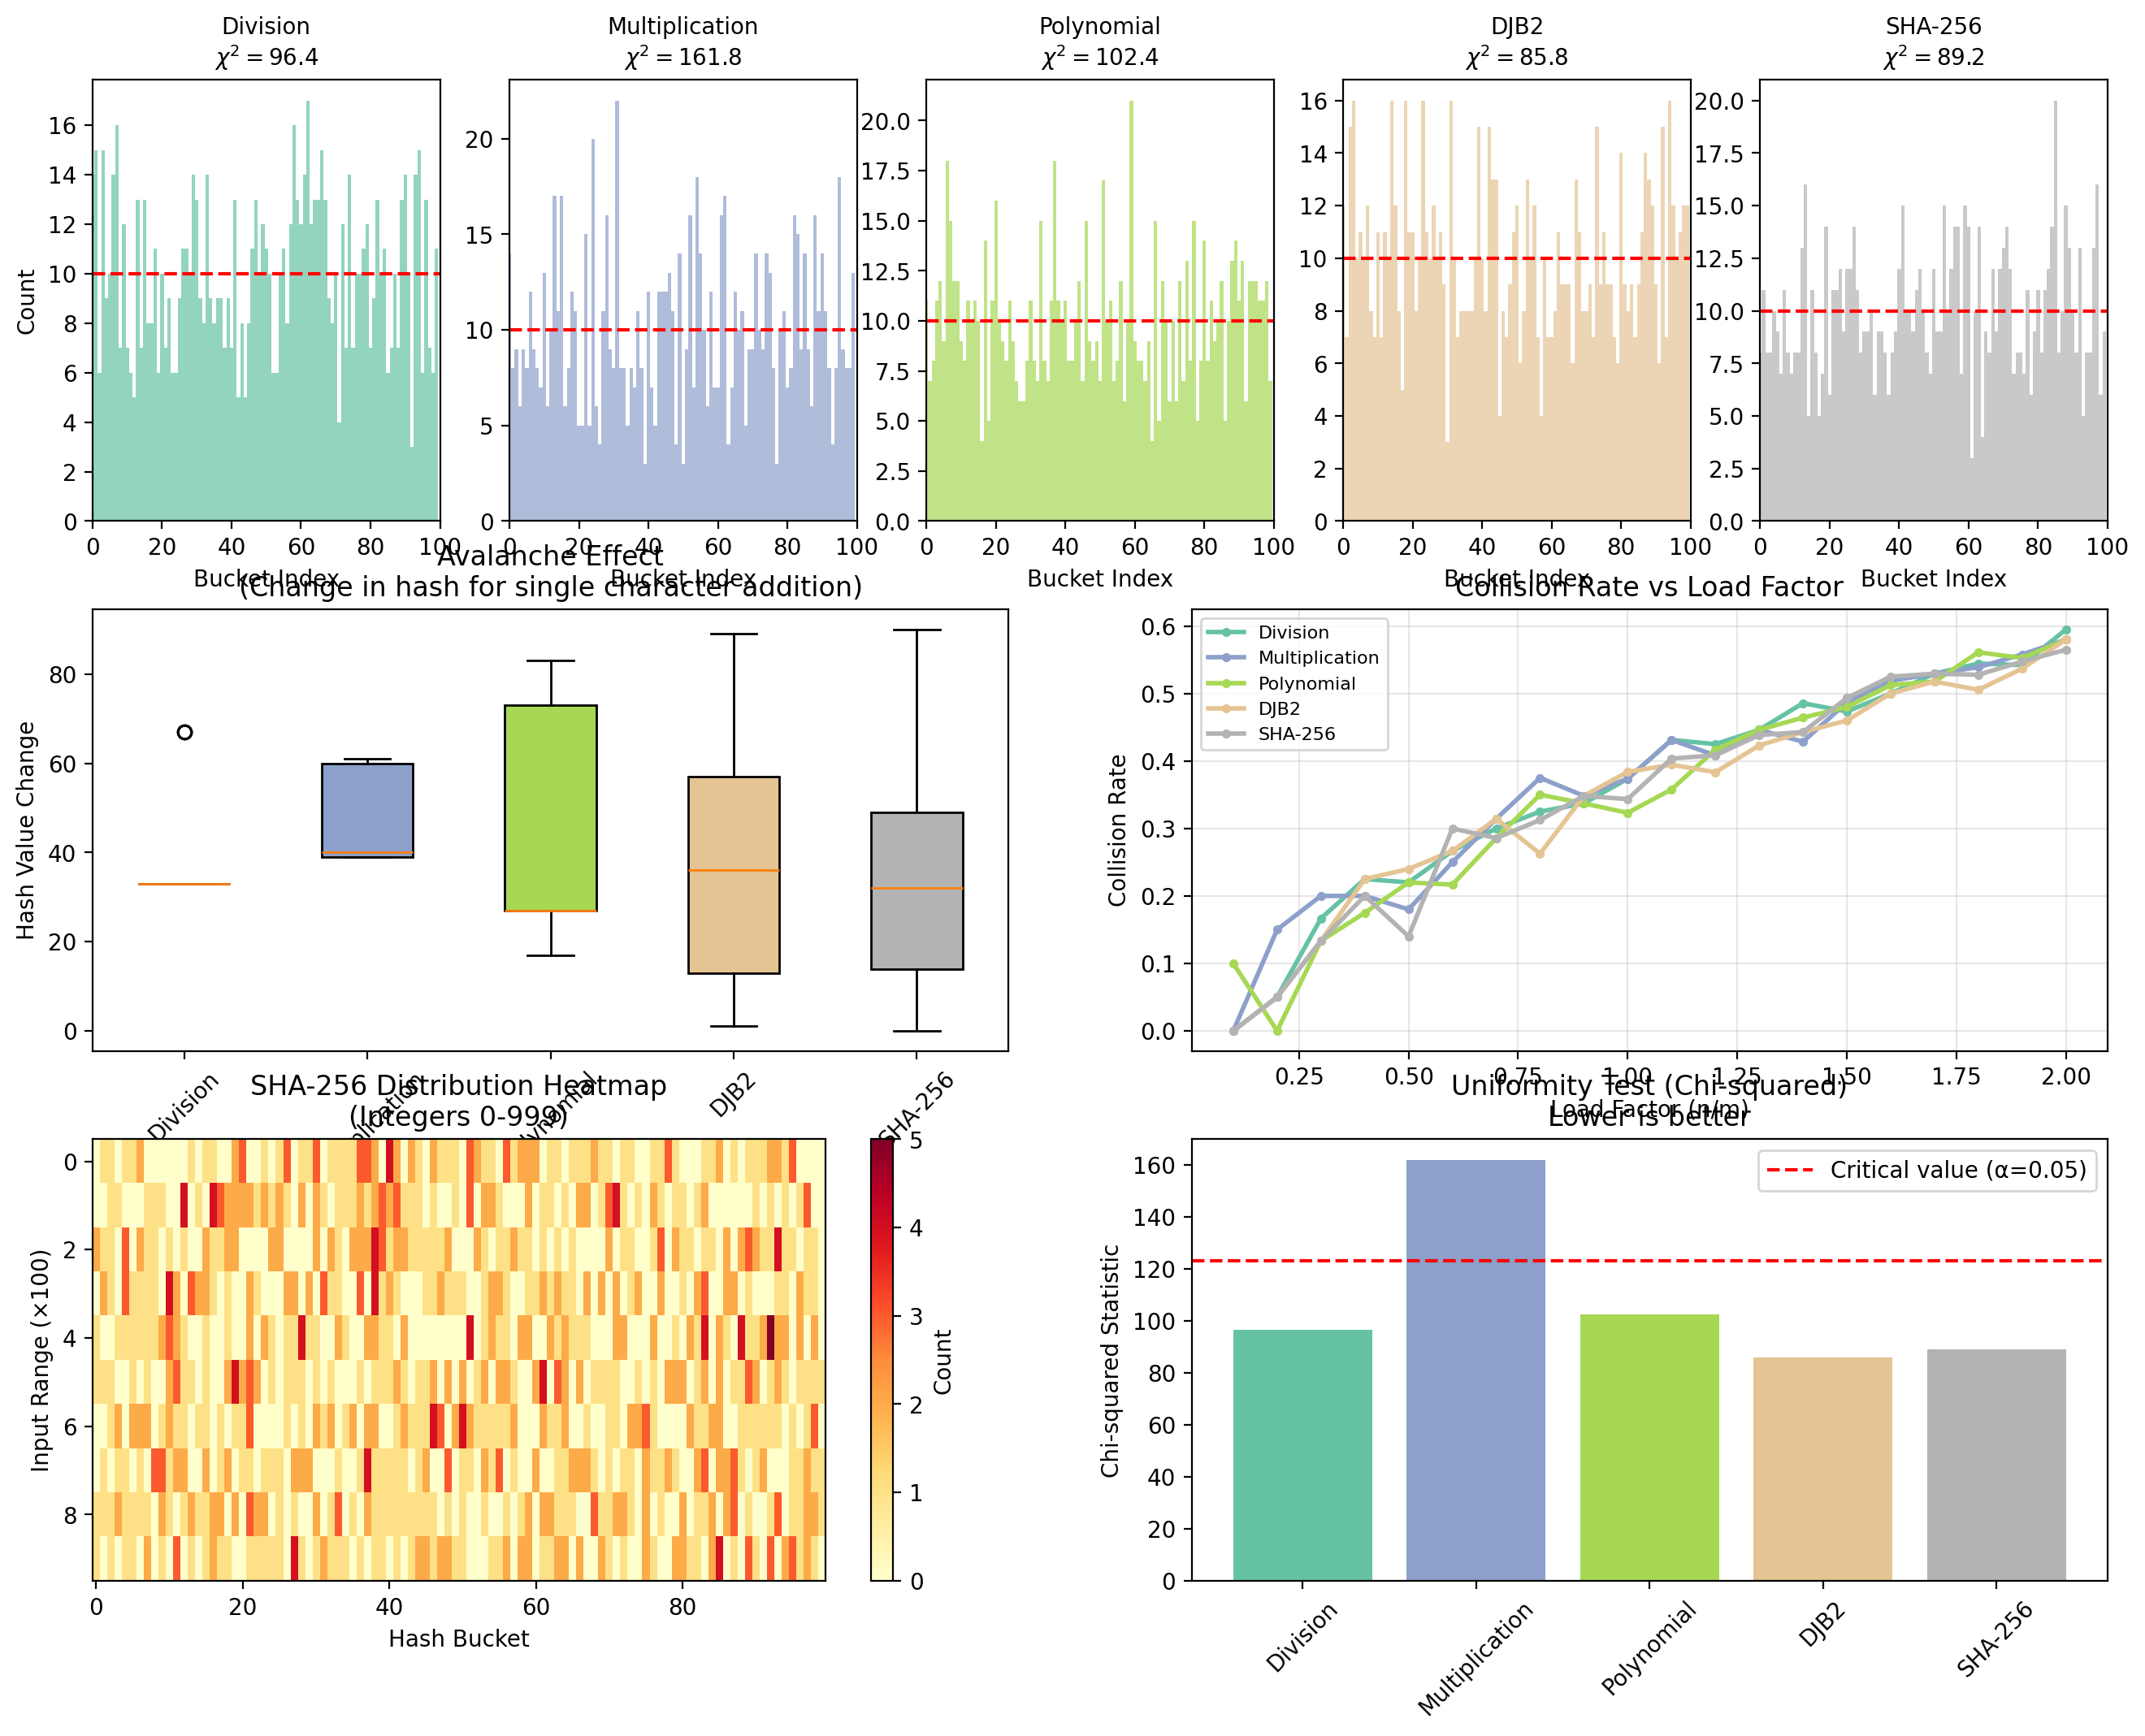


Visualization saved to plot.png


In [6]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Color palette
colors = plt.cm.Set2(np.linspace(0, 1, len(hash_functions)))

# 1. Distribution histograms (top row)
for idx, (name, result) in enumerate(results.items()):
    ax = fig.add_subplot(3, len(hash_functions), idx + 1)
    
    # Create histogram of bucket occupancy
    bucket_counts = [result['counts'].get(i, 0) for i in range(TABLE_SIZE)]
    ax.bar(range(TABLE_SIZE), bucket_counts, color=colors[idx], alpha=0.7, width=1.0)
    ax.axhline(y=n_samples/TABLE_SIZE, color='red', linestyle='--', 
               label=f'Expected={n_samples/TABLE_SIZE:.1f}')
    ax.set_title(f'{name}\n$\\chi^2={result["chi_squared"]:.1f}$', fontsize=10)
    ax.set_xlabel('Bucket Index')
    if idx == 0:
        ax.set_ylabel('Count')
    ax.set_xlim(0, TABLE_SIZE)

# 2. Avalanche effect visualization (middle row)
ax_avalanche = fig.add_subplot(3, 2, 3)

# Test avalanche effect: small input changes should cause large output changes
base_strings = [f'test{i}' for i in range(100)]
modified_strings = [f'test{i}!' for i in range(100)]  # Add single character

avalanche_data = {}
for name, func in hash_functions.items():
    base_hashes = [func(s) for s in base_strings]
    mod_hashes = [func(s) for s in modified_strings]
    changes = [abs(b - m) for b, m in zip(base_hashes, mod_hashes)]
    avalanche_data[name] = changes

bp = ax_avalanche.boxplot([avalanche_data[name] for name in hash_functions.keys()],
                          labels=hash_functions.keys(), patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax_avalanche.set_ylabel('Hash Value Change')
ax_avalanche.set_title('Avalanche Effect\n(Change in hash for single character addition)')
ax_avalanche.tick_params(axis='x', rotation=45)

# 3. Collision analysis (middle row)
ax_collision = fig.add_subplot(3, 2, 4)

# Calculate collisions for different load factors
load_factors = np.linspace(0.1, 2.0, 20)
collision_data = {name: [] for name in hash_functions.keys()}

for lf in load_factors:
    n_keys = int(TABLE_SIZE * lf)
    test_keys = [generate_random_string() for _ in range(n_keys)]
    
    for name, func in hash_functions.items():
        hashes = [func(k) for k in test_keys]
        unique_hashes = len(set(hashes))
        collisions = n_keys - unique_hashes
        collision_rate = collisions / n_keys if n_keys > 0 else 0
        collision_data[name].append(collision_rate)

for idx, (name, rates) in enumerate(collision_data.items()):
    ax_collision.plot(load_factors, rates, color=colors[idx], 
                      label=name, linewidth=2, marker='o', markersize=3)

ax_collision.set_xlabel('Load Factor (n/m)')
ax_collision.set_ylabel('Collision Rate')
ax_collision.set_title('Collision Rate vs Load Factor')
ax_collision.legend(loc='upper left', fontsize=8)
ax_collision.grid(True, alpha=0.3)

# 4. Heat map of hash distribution (bottom left)
ax_heat = fig.add_subplot(3, 2, 5)

# Create 2D visualization: hash of numbers 0-999
heat_data = np.zeros((10, TABLE_SIZE))
test_nums = list(range(1000))
sha_hashes = [sha256_hash(n) for n in test_nums]

for i, h in enumerate(sha_hashes):
    row = i // 100
    heat_data[row, h] += 1

im = ax_heat.imshow(heat_data, aspect='auto', cmap='YlOrRd')
ax_heat.set_xlabel('Hash Bucket')
ax_heat.set_ylabel('Input Range (×100)')
ax_heat.set_title('SHA-256 Distribution Heatmap\n(Integers 0-999)')
plt.colorbar(im, ax=ax_heat, label='Count')

# 5. Chi-squared comparison (bottom right)
ax_chi = fig.add_subplot(3, 2, 6)

chi_values = [results[name]['chi_squared'] for name in hash_functions.keys()]
bars = ax_chi.bar(hash_functions.keys(), chi_values, color=colors)

# Add critical value line (df = TABLE_SIZE - 1, α = 0.05)
# For df=99, critical value ≈ 123.2
critical_value = 123.2
ax_chi.axhline(y=critical_value, color='red', linestyle='--', 
               label=f'Critical value (α=0.05)')
ax_chi.set_ylabel('Chi-squared Statistic')
ax_chi.set_title('Uniformity Test (Chi-squared)\nLower is better')
ax_chi.tick_params(axis='x', rotation=45)
ax_chi.legend()

plt.tight_layout()
plt.savefig('hash_function_visualization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to plot.png")

## Conclusions

### Key Observations

1. **Distribution Quality**: The SHA-256 and DJB2 hash functions typically show the most uniform distribution, with lower $\chi^2$ statistics indicating better uniformity.

2. **Avalanche Effect**: Cryptographic hash functions (SHA-256) demonstrate stronger avalanche properties, where small input changes produce large, unpredictable output changes.

3. **Collision Behavior**: All hash functions follow similar collision curves, but the rate of increase with load factor varies:
   - For load factor $\alpha = n/m < 1$: Collisions grow approximately as $\frac{n^2}{2m}$
   - For $\alpha > 1$: Collision rate approaches $(1 - 1/m)$

4. **Trade-offs**:
   - **Division method**: Fast but poor distribution for certain patterns
   - **Multiplication method**: Good balance of speed and distribution
   - **Cryptographic hashes**: Best distribution but computationally expensive

### Recommendations

- For hash tables: Use multiplication method or DJB2 for good performance
- For security applications: Use cryptographic hashes (SHA-256)
- For string hashing: Polynomial or DJB2 provide excellent results
- Always choose table size $m$ to be prime for better distribution